# SARIMA 모델을 이용한 수익성 예측

- 참고 : https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d

## 시계열(Time Series)

#### 시간에 따른 연속형 변수의 예측 및 Trend 파악 
- 시간은 특정 간격을 가진 주기 ; Lag
- Lag에서 Data point의 특성을 찾는것 


#### 시계열 분석 모형 
- 일변량 정상시계열
    - ARIMA
    - 지수평활법
    
- 다변량 시계열
    - 전이함수모형


#### 시계열 패턴 
- 추세 (Trend)
- 계절성 (Seasonality)
- 주기 (Cycle) : 
- 잡음 (Noise) : 시간에 따라 독립적인 데이터 / White Noise : 통계적, 기술적 분석이 가능한 정도의 Noise

### ARIMA

- ARIMA 사용 시기 및 조건
    - 단기예측에 적합
    - 계절적 변동요인 (주기적 변동요인)
    - 표본의 크기가 최소 50개 이상 
    - 정상적(Stationary)자료에 적용 가능 
        - 평균이 증가/감소 -> 차분(Difference)을 실시
        - 분산이 증가/감소 -> Lag 변환
        

- AR (Auto Regressive Model) : 자기회귀모델 / p 시점 전의 자료가 현재 자료에 영향을 주는 자기회귀 모델
    - 자기상관함수 (ACF : Auto Correlation Function) 
        - p 구간 내 데이터 사이의 상관관계 (교회 - 범죄 - [인구])
        - 외부 요인으로 인해 독립적인 변수들 사이에 상관관계가 생김 
    - 부분자기상관함수 (PACF : Partial Auto Correlation Function) : 
        - 다른 시점의 데이터들의 영향을 제외한 두 관측치 사이의 상관관계 (교회 - 범죄 !- [인구])  
    - 일반적인 AR 모델에서는 ACF는 일정히 감소 / PACF가 절단면을 갖는다 
    - ACF와 PACF를 확인하여 분석 모델을 선택한다 
    
- MA(Moving Average Model) : 이동평균모델 / 일정한 p구간의 데이터들의 평균을 계산하여, 미래를 예측하는 방법
    - 시계열의 불규칙적인 변동을 제거하기 위함 

- Difference 
    - 정상성(Stationary)을 만족하지 못하는 시계열 데이터를 정상성이 만족하는 데이터로 변환 

In [77]:
# 필요한 라이브러리 import
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, style, font_manager, rc
import matplotlib as mpl
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
import chart_studio.plotly as py

In [78]:
# 한글폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [79]:
# 마이너스 깨질 때
mpl.rcParams['axes.unicode_minus']=False

In [111]:
# 그래프 예쁘게 해주는 시각화 tool(그래프 사이즈 조절 함수)
from pylab import rcParams

rcParams['figure.figsize'] = 15,10

In [112]:
#차트 기본 크기 설정
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

In [113]:
# ARIMA모델 사용 시, 통계기법 적용 가능한 라이브러리
import statsmodels.tsa.api as tsa

In [114]:
# 데이터 불러오기
df1=pd.read_csv('./data/월별 운수수익(2011.01-2022.10).csv',encoding='cp949')
df1.head()

,날짜,운수수익
0,2011-01-01,15397387803
1,2011-02-01,14464504026
2,2011-03-01,18460210060
3,2011-04-01,17512716113
4,2011-05-01,18066619791


<AxesSubplot:xlabel='날짜', ylabel='운수수익'>

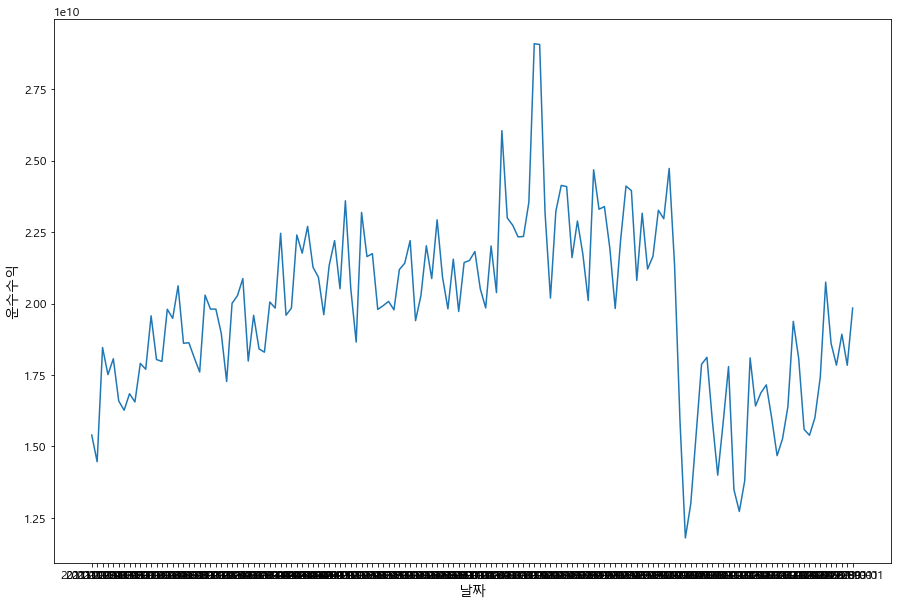

In [116]:
sns.lineplot(data=df1, x='날짜' ,y='운수수익', ci=None , estimator=sum)

## 시계열 테이블만들기 
- 시계열 분석 모델 대부분이 인덱스를 하나의 x깂으로 간주하고 분석
- 인덱스 자체에 시간에 대한 정보가 들어가야 가장 이상적인 형태의 데이터

In [117]:
# to_datetime으로 '날짜' 피처를 시계열 피처로 변환
df1['날짜'] = pd.to_datetime(df1['날짜'])

# '날짜'를 데이터프레임의 index로 설정
df1.index = df1['날짜']
df1.set_index('날짜', inplace=True)
df1.head()

,운수수익
날짜,
2011-01-01,15397387803
2011-02-01,14464504026
2011-03-01,18460210060
2011-04-01,17512716113
2011-05-01,18066619791


In [118]:
df1.describe()

,운수수익
count,1.420000e+02
mean,1.980958e+10
std,3.009243e+09
min,1.179852e+10
25%,1.792188e+10
50%,1.984218e+10
75%,2.175723e+10
max,2.909027e+10


In [119]:
# 한 달 단위의 평균 금액 계산
y = df1['운수수익'].resample('1M').mean()

In [120]:
y.isnull().sum()

0

In [121]:
y.head()

날짜
2011-01-31    1.539739e+10
2011-02-28    1.446450e+10
2011-03-31    1.846021e+10
2011-04-30    1.751272e+10
2011-05-31    1.806662e+10
Freq: M, Name: 운수수익, dtype: float64

In [89]:
# 단위 변동으로 인한 missing값 발생 시 사용
# y1 = y.fillna( y.mean())

## 시계열 분해
- seasonal_decompose 시계열 분석 모형

## 분해 시계열
- 시계열에 영향을 주는 일반적 요인을 시계열에서 분리해 분석하는 방법 
    - 계절요인 Seasonal
    - 추세요인 Trend 
    - 순환요인 Cyclical 
    - 불규칙요인 Irregular

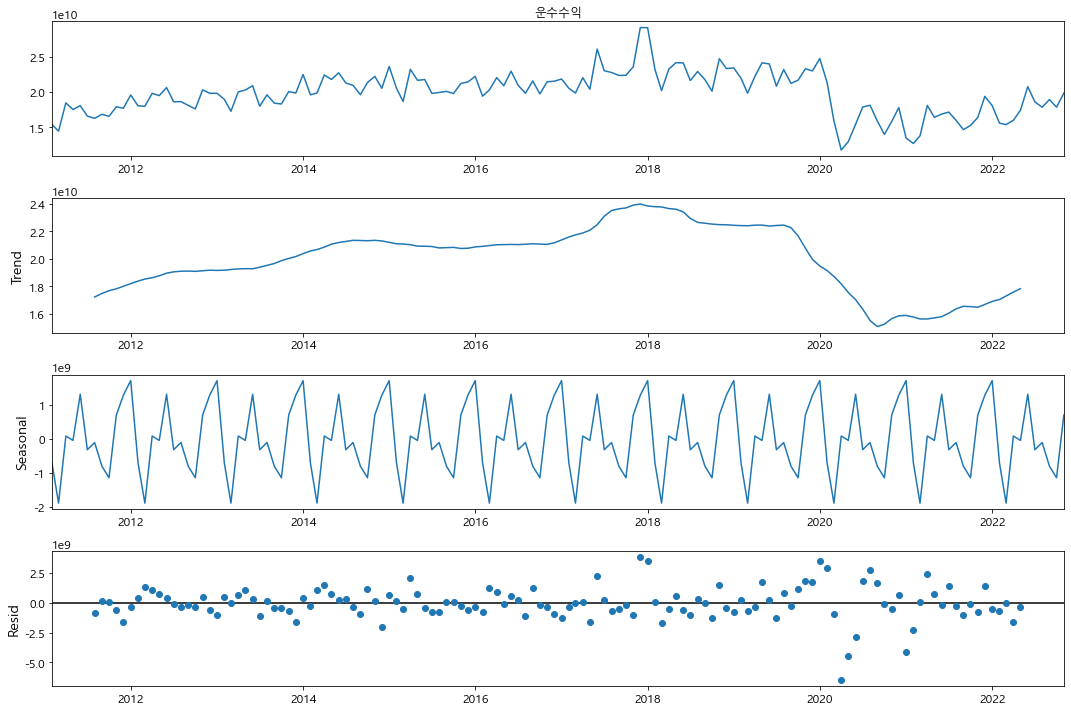

In [122]:
# 시계열 모델 생성
model_series = tsa.seasonal_decompose(y, model='additive')
# 모델 시각화
fig = model_series.plot()

plt.show()

## 시계열 분석 돌리기

In [123]:
# 반복수를 만드는 라이브러리
import itertools 

In [124]:
# 12가지의 난수를 생성 -> p, d, q 조합을 만들어 냄
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [125]:
# ARIMA모델의 파라미터
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [126]:
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [127]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

In [128]:
# p, d, q 각각에 해당하는 ARIMA모델 생성 시물레이션
# p, d, q 값들이 모델에 대해 유의미한지 계산 
for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            mod = tsa.statespace.SARIMAX(y,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
             continue

In [129]:
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})
#ARIMA_list.to_excel('arima_model_list.xlsx')

## 평가 지표
#### Likelihood (최대우도) : 특정 데이터가 모수로 부터 추출되었을 가능도
- 특정 값에 대한 분포의 확률 추정 (연속 확률 밀도함수 pdf의 y값)
- 특정 확률 분포에서 해당 값이 나온 확률의 개념과 반대 


#### AIC (Akaike Information Criterion, 아카이케 정보기준) : 데이터에 대한 모델의 상대적 품질을 수치화
- AIC = -2 ln(L) + 2k   (L : Likelihood function, k : Parameter) -> 최대우도 함수에 특정 파라미터 값을 더함
- 모형 적합도 함수를 이용해 계산 
- 값이 낮을 수록 모형 적합도가 높은것을 의미함 
   
    
#### BIC (Bayes Information Criterion, 베이지안 정보기준) : 데이터에 대한 모델의 상대적 품질을 수치화
- BIC = -2 ln(L) + log(n)p 
- 변수가 더 많은 경우, AIC에 더 많은 패널티를 부여 
- 변수가 많아질수록 AIC 값보다 높게 나올 가능성이 있다
    
#### HQIC (Hannan-Quinn Information Criterion, 해넌 퀸 정보기준) : 데이터에 대한 모델의 상대적 품질을 수치화
- HQC = -2 ln(L) + 2k ln(ln(n))
- AIC 와 BIC 값의 대안 , Likelihood에 대한 미세 조정 함수로 사용 

In [130]:
# 가장 성능이 좋았던 파라미터 찾기
# AIC 값이 낮을수록 변동이 없고 정확한 모델임
ARIMA_list.sort_values(by='AIC')

# 데이터에 대한 적절한 모델 찾음

,Parameter,Seasonal,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",5254.697399
59,"(1, 1, 1)","(0, 1, 1, 12)",5256.781644
31,"(0, 1, 1)","(1, 1, 1, 12)",5257.349642
27,"(0, 1, 1)","(0, 1, 1, 12)",5260.043541
47,"(1, 0, 1)","(1, 1, 1, 12)",5298.957101
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 12)",6408.799553
12,"(0, 0, 1)","(1, 0, 0, 12)",6415.004371
32,"(1, 0, 0)","(0, 0, 0, 12)",6446.696061
8,"(0, 0, 1)","(0, 0, 0, 12)",6946.054494


In [131]:
# 구축된 모델을 사용하여 통계지표 평가 -> 최종적으로 사용할 모델 결정
mod = tsa.statespace.SARIMAX(y,order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               운수수익   No. Observations:                  142
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2622.349
Date:                            Mon, 14 Nov 2022   AIC                           5254.697
Time:                                    18:51:48   BIC                           5268.422
Sample:                                01-31-2011   HQIC                          5260.268
                                     - 10-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3397      0.270      1.256      0.209      -0.190       0.870
ma.L1         -0.6601      0.205   

### SARIMAX Result 
- Trend 여부에 대해 ARIMA Model을 생성하고, Seasonal에 대해서 ARIMA Model을 추가적으로 수행한 모델 
- Order (p,d,q) , Seasonal Order (P,D,Q,M) -> 계절성이 없는 파라미터에 계절성이 들어가 있는 파라미터를 추가해서 만든 모델
    - p : AR에서의 p 값 (p 구간 내 데이터 사이의 상관관계)
    - d : 차분 값 
    - q : MA에서 PACF에서 편상관계수 q 값  
    - P : PACF에서 계절성 주기의 패턴이 어떻게 되는지 
    - D : 계절성 여부 확인 (1/0)
    - Q : ACF 함수를 기준으로 계절성 주기의 패턴이 어떻게 되는지 (계절성 반복 수)
    - M : 계절성 주기 값 

### Ljung-Box Test (륭 박스 검정) : 일정 기간 동안 관측치가 랜덤이고 독립적인지 여부를 검정
- 귀무가설 : 데이터가 상관관계를 나타내지 않는다. (상관계수 = 0)
- 대립가설 : 데이터가 상관관계를 나타낸다. (상관계수 != 0)
- 0.05 보다 작으면, 대립가설 채택 (데이터가 상관관계를 나타낸다, 해당 회귀 계수는 유의미하다) 

### Jarque - Bera Test (쟈크베라 검정) : 데이터의 왜도와 첨도가 정규분포와 일치하는지 가설검정
- SARIMAX에서 잔차(residual)의 분포가 정규분포를 띄는지 확인 
- 귀무가설 : 해당 Sample은 정규분포와 일치한다.
- 대립가설 : 해당 Sample은 정규분포와 일치하지 않는다. 

### Heteroskedasticity Test (이분산 검정)
- SARIMAX에서 잔차(Residual)의 분산에 대한 이분산 검정 

### Warnings
- [1] 공분산 행렬에 대한 설명 
- [2] 모수의 추청치가 불안정 하다는 의미 
    - 과적합이 발생한 경우 (또는 다른 요인에 의해 오차의 변동이 심한 것을 확인)
    - 더 간단한 모델을 사용하여 해결 (Overfitting을 방지하는 방향으로) 

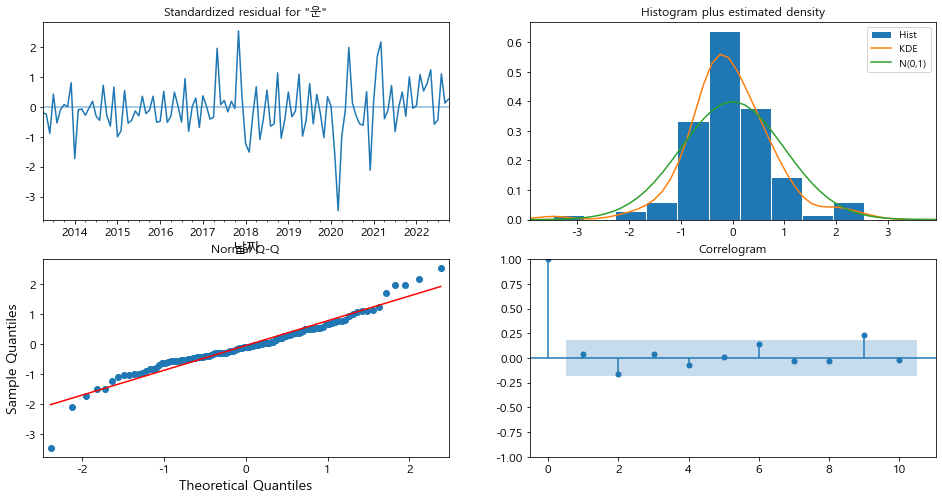

In [132]:
# 모델 적합 결과 시각화
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [133]:
results.get_prediction()

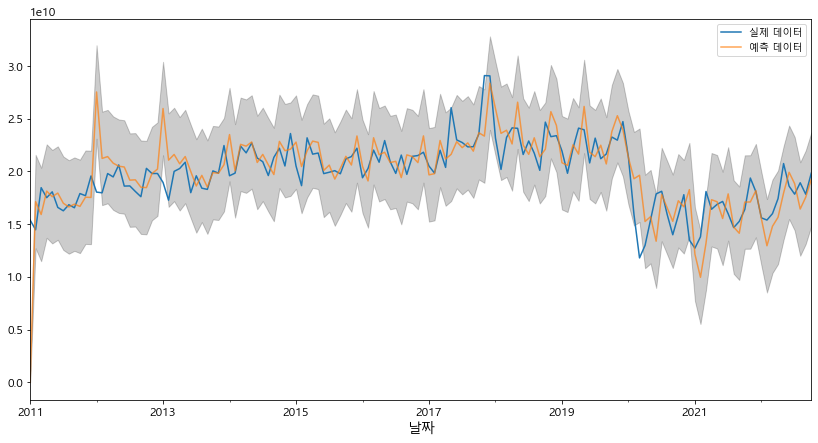

In [134]:
# 실제 데이터와 예측 데이터 비교

# 실제 데이터와 비교하여 예측할 기간 결정 
pred = results.get_prediction(start=pd.to_datetime('2011-01-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = y.plot(label='실제 데이터')
pred.predicted_mean.plot(ax=ax, label='예측 데이터', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

In [135]:
pred = results.get_prediction(start=pd.to_datetime('2011-01-31'), dynamic=False)
pd.DataFrame(pred.predicted_mean).reset_index()

,날짜,predicted_mean
0,2011-01-31,0.000000e+00
1,2011-02-28,1.714077e+10
2,2011-03-31,1.591419e+10
3,2011-04-30,1.813686e+10
4,2011-05-31,1.760287e+10
...,...,...
137,2022-06-30,1.992021e+10
138,2022-07-31,1.883816e+10
139,2022-08-31,1.643434e+10
140,2022-09-30,1.755450e+10


In [136]:
y_forecasted = pred.predicted_mean
y_truth = y['2011-01-31':]
mse = ((y_forecasted - y_truth) ** 2).mean()
# MSE : 평균 제곱 오차
print('MSE {}'.format(round(mse, 2)))

MSE 5.95476479188908e+18


In [144]:
# 향후 50개월 예측값
pred_uc = results.get_forecast(steps=50)

In [145]:
pred_uc.predicted_mean

2022-11-30    2.128440e+10
2022-12-31    1.925700e+10
2023-01-31    1.731833e+10
2023-02-28    1.658950e+10
2023-03-31    1.819041e+10
2023-04-30    1.821896e+10
2023-05-31    1.988075e+10
2023-06-30    1.944792e+10
2023-07-31    1.893703e+10
2023-08-31    1.818528e+10
2023-09-30    1.777313e+10
2023-10-31    1.940141e+10
2023-11-30    2.143952e+10
2023-12-31    1.967730e+10
2024-01-31    1.758448e+10
2024-02-29    1.702152e+10
2024-03-31    1.831635e+10
2024-04-30    1.877777e+10
2024-05-31    2.095643e+10
2024-06-30    1.999268e+10
2024-07-31    1.940444e+10
2024-08-31    1.922169e+10
2024-09-30    1.860038e+10
2024-10-31    2.034411e+10
2024-11-30    2.219809e+10
2024-12-31    2.035360e+10
2025-01-31    1.830860e+10
2025-02-28    1.769419e+10
2025-03-31    1.908397e+10
2025-04-30    1.941111e+10
2025-05-31    2.142941e+10
2025-06-30    2.063038e+10
2025-07-31    2.006613e+10
2025-08-31    1.970686e+10
2025-09-30    1.915043e+10
2025-10-31    2.085835e+10
2025-11-30    2.276945e+10
2

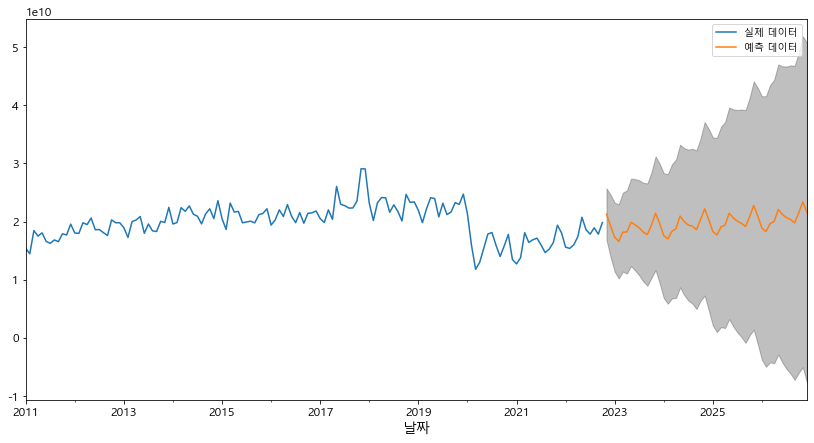

In [148]:
# 향후 50개월 예측값 시각화
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int() # 추정된 계수의 신뢰구간 계산
ax = y.plot(label='실제 데이터', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='예측 데이터')
ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()
plt.show()